In [2]:
import numpy as np
import pandas as pd
import sys
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Methods

In [3]:
# excluding data of teaching staff and other
ranks = ['professor', 'associate professor', 'assistant professor']
def get_departmental_df(school):
    all_dict = []
    for department in school:
        department_name = department.get('department')
        if department.get('gender_race_data') is not None:
            all_row = {"department": department_name, "rank":"all", 
                       "gender_female":0, "gender_male":0, "race_white":0, 
                       "race_api":0, "race_black":0, "race_hispanic":0, 
                       "gender_unknown":0, "race_unknown":0}
            for k,v in department.get('gender_race_data').items():
                if k not in ranks:
                    continue
                dictionary = {'department': department_name}
                dictionary.update({'rank': k})
                gender_race_data = v
                # gender
                no_genders = gender_race_data.get('no_genders')
                for k1, v1 in no_genders.items():
                    dictionary.update({'gender_'+k1: v1})
                    all_row.update({'gender_'+k1: all_row['gender_'+k1] + v1})

                # race
                no_races = gender_race_data.get('no_races')
                for k2, v2 in no_races.items():
                    dictionary.update({'race_'+k2: v2})
                    all_row.update({'race_'+k2: all_row['race_'+k2] + v2})

                all_dict.append(dictionary)
            all_dict.append(all_row)
    df = pd.DataFrame(all_dict)

    return df

In [4]:
def get_pct_df(df):
    pct_df = pd.DataFrame()
    if 'department' in df.columns:
        pct_df['department'] = df['department']
    pct_df['rank'] = df['rank']
    # pecentages excludes unknown
    pct_df['female_pct'] = df['gender_female']/(df['gender_female'] + df['gender_male'])
    pct_df['white_pct'] = df['race_white']/(df['race_white'] + df['race_api'] + df['race_black'] + df['race_hispanic'])
    pct_df['api_pct'] = df['race_api']/(df['race_white'] + df['race_api'] + df['race_black'] + df['race_hispanic'])
    pct_df['black_pct'] = df['race_black']/(df['race_white'] + df['race_api'] + df['race_black'] + df['race_hispanic'])
    pct_df['hispanic_pct'] = df['race_hispanic']/(df['race_white'] + df['race_api'] + df['race_black'] + df['race_hispanic'])
    pct_df['gender_unknown_pct'] = df['gender_unknown']/(df['gender_female']+ df['gender_male']+ df['gender_unknown'])
    pct_df['race_unknown_pct'] = df['race_unknown']/(df['race_unknown'] + df['race_white'] + df['race_api'] + df['race_black'] + df['race_hispanic'])
    return pct_df

In [5]:
def get_whole_school_pct_df(the_departmental_df):
    the_whole_school_df = the_departmental_df.groupby('rank').sum(0).drop(columns='department').reset_index()
    the_whole_school_pct_df = get_pct_df(the_whole_school_df)
    return the_whole_school_pct_df

In [6]:
def get_pct(df, rank, feature):
    return float(df.loc[df['rank'] == rank, f'{feature}_pct']) * 100

# Data Visualization

In [7]:
schools = ["columbia", "dartmouth", "yale", "princeton", "brown", "cornell", "upenn", "harvard"]

In [8]:
the_schools = {}
for school in schools:
    with open(sys.path[0] + f'/../data/{school}/{school}_v2_finalized.json', 'r') as f:
        the_school = json.load(f)
    the_schools.update({school: the_school})

In [9]:
departmental_dfs = {}
departmental_pct_dfs = {}
whole_school_pct_dfs = {}

for school in schools:
    the_school = the_schools.get(school)
    
    # departmental
    the_departmental_df = get_departmental_df(the_school)
    departmental_dfs.update({school: the_departmental_df})
    
    # departmental pct
    the_departmental_pct_df = get_pct_df(the_departmental_df)
    the_departmental_pct_df.to_json(sys.path[0] + f'/../output/{school}_departmental_pct_v2.json', orient='records')
    departmental_pct_dfs.update({school: the_departmental_pct_df})
    
    # whole school pct
    the_whole_school_pct_df = get_whole_school_pct_df(the_departmental_df)
    the_whole_school_pct_df.to_json(sys.path[0] + f'/../output/{school}_whole_school_pct_v2.json', orient='records')
    whole_school_pct_dfs.update({school:the_whole_school_pct_df})

In [10]:
departmental_dfs.get('columbia').head()

,department,rank,gender_female,gender_male,gender_unknown,race_white,race_black,race_api,race_hispanic,race_unknown
0,Accounting Division,professor,0,9,0,8,0,0,1,0
1,Accounting Division,associate professor,1,2,0,2,0,1,0,0
2,Accounting Division,assistant professor,3,7,0,5,0,4,0,1
3,Accounting Division,all,4,18,0,15,0,5,1,1
4,African American and African Diaspora Studies ...,professor,5,8,0,0,13,0,0,0


In [11]:
departmental_pct_dfs.get('columbia').head()

,department,rank,female_pct,white_pct,api_pct,black_pct,hispanic_pct,gender_unknown_pct,race_unknown_pct
0,Accounting Division,professor,0.000000,0.888889,0.000000,0.0,0.111111,0.0,0.000000
1,Accounting Division,associate professor,0.333333,0.666667,0.333333,0.0,0.000000,0.0,0.000000
2,Accounting Division,assistant professor,0.300000,0.555556,0.444444,0.0,0.000000,0.0,0.100000
3,Accounting Division,all,0.181818,0.714286,0.238095,0.0,0.047619,0.0,0.045455
4,African American and African Diaspora Studies ...,professor,0.384615,0.000000,0.000000,1.0,0.000000,0.0,0.000000


In [12]:
whole_school_pct_dfs.get('columbia')

,rank,female_pct,white_pct,api_pct,black_pct,hispanic_pct,gender_unknown_pct,race_unknown_pct
0,all,0.382034,0.700965,0.152733,0.073955,0.072347,0.026144,0.061840
1,assistant professor,0.489691,0.668421,0.178947,0.073684,0.078947,0.031614,0.051581
2,associate professor,0.419940,0.705329,0.131661,0.094044,0.068966,0.014881,0.050595
3,professor,0.308594,0.718526,0.144319,0.067554,0.069601,0.026616,0.071293


In [12]:
bins = [5*i/100 for i in range(21)]

In [13]:
print(bins)

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


## Unknown data

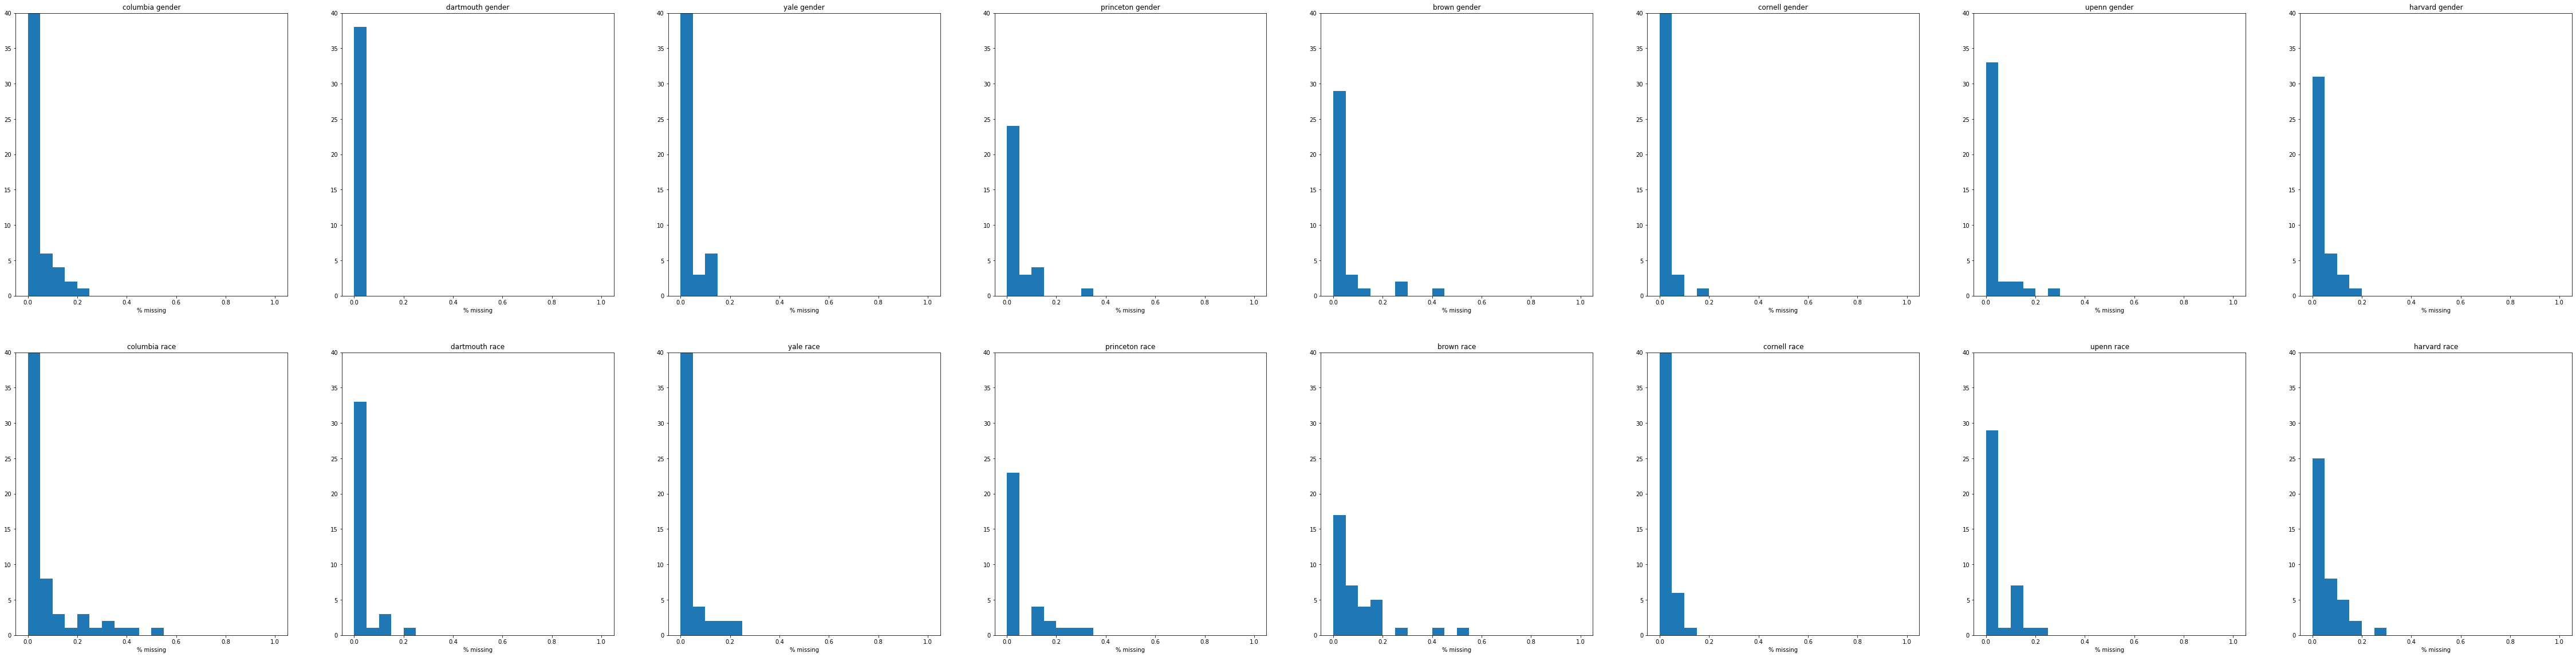

In [14]:
fig, axs = plt.subplots(2, 8, figsize=(80,20))
curr_ind = 0
for school in schools:
    the_departmental_pct_df = departmental_pct_dfs.get(school)
    titles = ['gender', 'race']
    features = ['gender_unknown_pct', 'race_unknown_pct']
    for i in range(2):
        values = the_departmental_pct_df.loc[the_departmental_pct_df['rank']=='all', features[i]]
        axs[i, curr_ind].hist(the_departmental_pct_df.loc[the_departmental_pct_df['rank']=='all', features[i]], bins=bins)
        axs[i, curr_ind].set_title(school+ " "+ titles[i])
        axs[i, curr_ind].set_ylim(0,40)
        axs[i, curr_ind].set_xlabel('% missing')
    curr_ind += 1

plt.show()

## Whole school pct (female and non-white)

In [18]:
female_pcts = []
non_white_pcts = []

for school in schools:
    the_school_df = whole_school_pct_dfs.get(school)
    female_pct = get_pct(the_school_df, 'all', 'female')
    female_pcts.append(female_pct)
    
    non_white_pct = 100 - get_pct(the_school_df, 'all', 'white')
    non_white_pcts.append(non_white_pct)

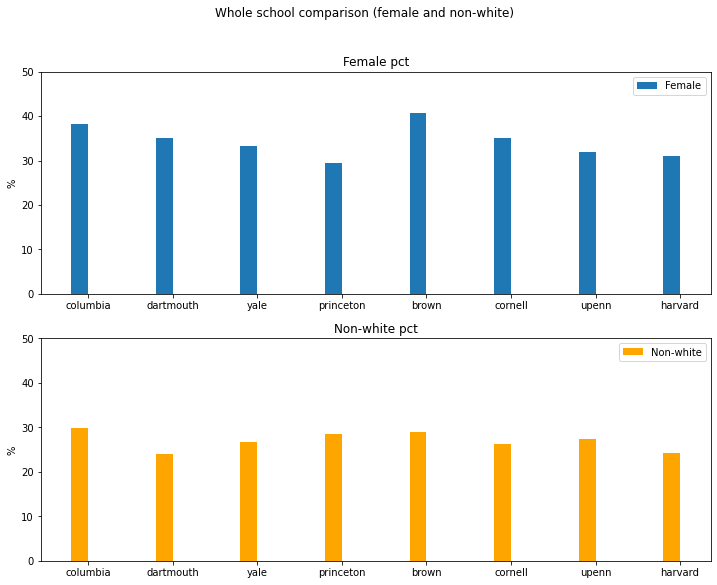

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
fig.suptitle('Whole school comparison (female and non-white)')

# Number of bars
N = 8
# Position of bars on x-axis
ind = np.arange(N)
width = 0.2
features = ['female pct', 'non-white pct']

ax1.set_title('Female pct')
ax1.bar(ind, female_pcts, width, label='Female')

ax2.set_title('Non-white pct')
ax2.bar(ind, non_white_pcts, width, label='Non-white', color='orange')

for ax in (ax1, ax2):
    ax.set_ylim(0,50)
    ax.set_ylabel('%')
    ax.set_xticks(ind + width / 2)
    ax.legend(loc='best')
    ax.set_xticklabels(schools)

plt.show()

## Whole school comparison between ranks

In [20]:
female_pcts = {}
non_white_pcts = {}

for school in schools:
    the_school_df = whole_school_pct_dfs.get(school)
    
    for rank in ranks:
        female_pct = get_pct(the_school_df, rank, 'female')
        non_white_pct = 100 - get_pct(the_school_df, rank, 'white')
        
        if school not in female_pcts.keys():
            female_pcts.update({school:[female_pct]})
            non_white_pcts.update({school:[non_white_pct]})
        else:
            female_pcts.get(school).append(female_pct)
            non_white_pcts.get(school).append(non_white_pct)

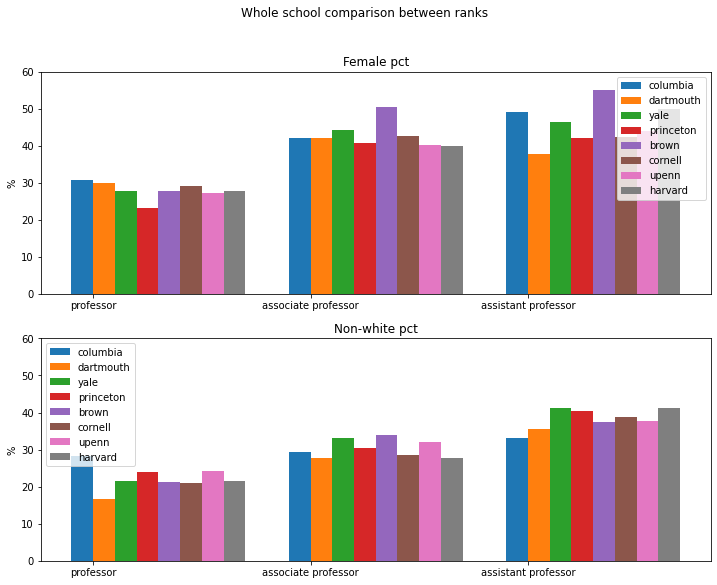

In [21]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
fig.suptitle('Whole school comparison between ranks')

# Number of bars
N = 3
# Position of bars on x-axis
ind = np.arange(N)
# Width of a bar 
width = 0.1

# female pct
ax1.set_title('Female pct')
curr_ind = ind
for school in schools:
    values = female_pcts.get(school)
    ax1.bar(curr_ind, values, width, label=school)
    curr_ind = curr_ind + width

# non-white pct
ax2.set_title('Non-white pct')
curr_ind = ind
for school in schools:
    values = non_white_pcts.get(school)
    ax2.bar(curr_ind, values, width, label=school)
    curr_ind = curr_ind + width

for ax in (ax1, ax2):
    ax.set_ylim(0,60)
    ax.set_ylabel('%')
    ax.set_xticks(ind + width / 2)
    ax.legend(loc='best')
    ax.set_xticklabels(ranks)

plt.show()

# Comparison with NCES data

In [25]:
NCES_data = {}
for school in schools:
    with open(sys.path[0] + f'/../data/{school}/data_during_process/{school}_NCES.json', 'r') as f:
        the_school_NCES = json.load(f)
        NCES_data[school] = the_school_NCES

In [26]:
ranks = ["professors", "associate professors", "assistant professors"]
NCES_dfs = {}
for school in schools:
    school_dict = NCES_data[school]
    school_NCES = []
    for rank in ranks:
        row = {}
        row["rank"] = rank[:-1]
        row["female"] = 0
        row["total"] = 0
        row["white"] = 0
        row["api"] = 0
        row["black"] = 0
        row["hispanic"] = 0
        row["aian"] = 0
        # total
        for gender, gender_dict in school_dict.items():
            for race, race_dict in gender_dict.items():
                val = race_dict[rank]
                row.update({"total": row["total"] + val})
                row.update({race: row[race] + val})
                if gender == "female":
                    row.update({'female': row['female'] + val})

        school_NCES.append(row)

    df = pd.DataFrame(school_NCES)
    all_row = {"rank":"all"}
    for col in df.columns[1:]:
        all_row.update({col: df[col].sum()})
    df.append(all_row, ignore_index=True)
    NCES_dfs.update({school: df})

In [27]:
NCES_pct_dfs = {}
for school, df in NCES_dfs.items():
    categories = ["female", "white", "api", "black", "hispanic"]
    df_pct = df.copy()
    for category in categories:
        df_pct[category + "_pct"] = df[category]/df["total"]
    df_pct = df_pct.iloc[:, [0,8,9,10,11,12]]
    NCES_pct_dfs.update({school: df_pct})

In [28]:
NCES_pct_dfs["princeton"]

,rank,female_pct,white_pct,api_pct,black_pct,hispanic_pct
0,professor,0.253731,0.827292,0.104478,0.042644,0.025586
1,associate professor,0.410256,0.794872,0.111111,0.025641,0.068376
2,assistant professor,0.404959,0.685950,0.173554,0.057851,0.082645


In [29]:
for school, data in NCES_pct_dfs.items():
    data.to_json(sys.path[0] + f'/../data/{school}/{school}_NCES_pct.json', orient='records')

In [30]:
ranks = ['professor', 'associate professor', 'assistant professor']
female_pcts_NCES = {}
non_white_pcts_NCES = {}

for school in schools:
    the_school_NCES_df = NCES_pct_dfs.get(school)
    
    for rank in ranks:
        female_pct_NCES = get_pct(the_school_NCES_df, rank, 'female')
        non_white_pct_NCES = 100 - get_pct(the_school_NCES_df, rank, 'white')
        
        if school not in female_pcts_NCES.keys():
            female_pcts_NCES.update({school:[female_pct_NCES]})
            non_white_pcts_NCES.update({school:[non_white_pct_NCES]})
        else:
            female_pcts_NCES.get(school).append(female_pct_NCES)
            non_white_pcts_NCES.get(school).append(non_white_pct_NCES)

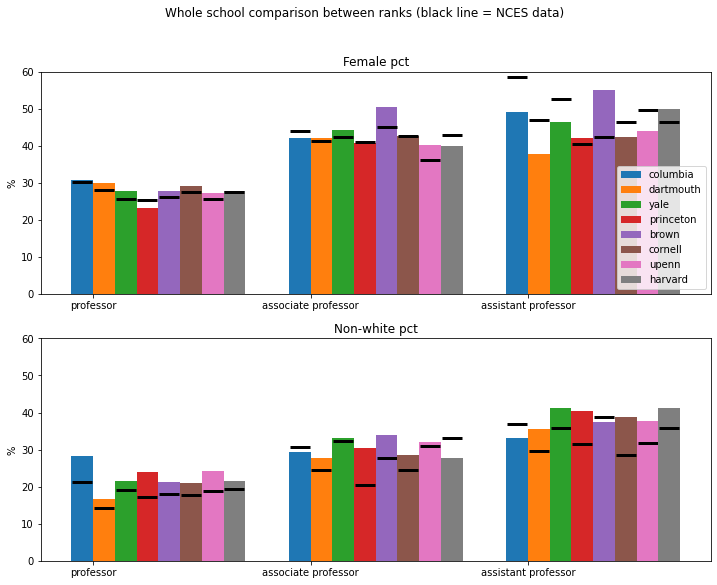

In [31]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
fig.suptitle('Whole school comparison between ranks (black line = NCES data)')

# Number of bars
N = 3
# Position of bars on x-axis
ind = np.arange(N)
# Width of a bar 
width = 0.1

# female pct
ax1.set_title('Female pct')
curr_ind = ind
for school in schools:
    values = female_pcts.get(school)
    values_NCES = female_pcts_NCES.get(school)
    ax1.bar(curr_ind, values, width, label=school)
    ax1.scatter(curr_ind, values_NCES, marker="_", s=400,linewidths=3, color="black")
    curr_ind = curr_ind + width

# non-white pct
ax2.set_title('Non-white pct')
curr_ind = ind
for school in schools:
    values = non_white_pcts.get(school)
    values_NCES = non_white_pcts_NCES.get(school)
    ax2.bar(curr_ind, values, width, label=school)
    ax2.scatter(curr_ind, values_NCES, marker="_", s=400,linewidths=3, color="black")
    curr_ind = curr_ind + width

for ax in (ax1, ax2):
    ax.set_ylim(0,60)
    ax.set_ylabel('%')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(ranks)
ax1.legend(loc='best')
    
plt.show()